In [1]:
%matplotlib inline

In [2]:
import os
import sys

In [3]:
print sys.version

2.7.14 (default, Jan 17 2018, 15:13:18) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import xgboost as xgb
import pymatgen as mg
import datetime as dt

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [6]:
from utils import rmsle

#### Load data

In [7]:
DATA_DIR = './data'

In [8]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma', 'E0',
                           'bandgap'],
                    header=0,
                    sep=',')
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma'],
                    header=0,
                    sep=',')

In [9]:
train_ext = pd.read_csv(os.path.join(DATA_DIR, 'train_ext.csv'),
                    header=0,
                    sep=',')
test_ext = pd.read_csv(os.path.join(DATA_DIR, 'test_ext.csv'),
                    header=0,
                    sep=',')

In [10]:
train = train.merge(train_ext, on='id')
test = test.merge(test_ext, on='id')

#### Add the spacegroup_natoms category:

In [11]:
train['spacegroup_natoms'] = train['spacegroup'].astype(str) +\
    '_' + train['natoms'].astype(int).astype(str)
test['spacegroup_natoms'] = test['spacegroup'].astype(str) +\
    '_' + test['natoms'].astype(int).astype(str)

#### Add cell volume and calculate atomic and mass density:

In [12]:
train['cellvol'] = train.apply(lambda r: mg.Lattice.from_parameters(r['a'], r['b'], r['c'],
                                         r['alpha'], r['beta'], r['gamma']).volume,
                               axis=1)
test['cellvol'] = test.apply(lambda r: mg.Lattice.from_parameters(r['a'], r['b'], r['c'],
                                       r['alpha'], r['beta'], r['gamma']).volume,
                             axis=1)

In [13]:
train['atom_density'] = train['natoms'] / train['cellvol']
test['atom_density'] = test['natoms'] / test['cellvol']

In [14]:
train['mass_density'] = train['avg_mass'] / train['cellvol']
test['mass_density'] = test['avg_mass'] / test['cellvol']

#### Convert angles to radians:

In [15]:
train['alpha_r'] = np.radians(train['alpha'])
train['beta_r'] = np.radians(train['beta'])
train['gamma_r'] = np.radians(train['gamma'])
test['alpha_r'] = np.radians(test['alpha'])
test['beta_r'] = np.radians(test['beta'])
test['gamma_r'] = np.radians(test['gamma'])

#### Check O fraction = 0.6:

In [16]:
train['o_fraction'] = train['o_cnt'] / train['natoms']
test['o_fraction'] = test['o_cnt'] / test['natoms']

#### Build train and test data sets:

In [17]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass'], axis=1)

In [18]:
# Use log1p of energies to correct for skew
y_bg_train = train['bandgap']
y_e0_train = np.log1p(train['E0'])

In [19]:
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

In [25]:
# Features list
X_train.columns.tolist()

['al',
 'in',
 'a',
 'b',
 'c',
 'avg_elec',
 'avg_ea',
 'avg_ip',
 'avg_rs_max',
 'avg_rp_max',
 'avg_rd_max',
 'atom_density',
 'mass_density',
 'alpha_r',
 'beta_r',
 'gamma_r',
 '12_20',
 '12_80',
 '167_30',
 '167_60',
 '194_10',
 '194_80',
 '206_80',
 '227_40',
 '33_40',
 '33_80']

In [26]:
# Create DMatrix for train
dtrain_bg = xgb.DMatrix(data=X_train, label=y_bg_train)
dtrain_e0 = xgb.DMatrix(data=X_train, label=y_e0_train)
dtest = xgb.DMatrix(data=X_test)

#### Build the XGBoost models and train

In [28]:
param = {'eta': 0.1,                 # Step size shrinkage used in update (Learning rate)
         'alpha': 0.10,              # L1 regularization term on weights
         'max_depth': 5,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'objective': 'reg:linear'}
num_round = 1000

In [29]:
result_e0 = xgb.cv(param, dtrain_e0, num_round, nfold=5,
                   metrics={'rmse'}, seed=42,
                   callbacks=[xgb.callback.print_evaluation(show_stdv=True)],
                   early_stopping_rounds=10)

[0]	train-rmse:0.309501+0.00103304	test-rmse:0.309558+0.00434323
[1]	train-rmse:0.279436+0.000914552	test-rmse:0.279586+0.00397396
[2]	train-rmse:0.252405+0.000820455	test-rmse:0.252668+0.00355557
[3]	train-rmse:0.228119+0.000726328	test-rmse:0.228439+0.00326878
[4]	train-rmse:0.206252+0.000642594	test-rmse:0.206658+0.00294549
[5]	train-rmse:0.186566+0.000558539	test-rmse:0.187065+0.00267513
[6]	train-rmse:0.168911+0.000481572	test-rmse:0.169607+0.00242109
[7]	train-rmse:0.153025+0.000410344	test-rmse:0.153828+0.00220987
[8]	train-rmse:0.13874+0.000363647	test-rmse:0.13974+0.00188016
[9]	train-rmse:0.12593+0.000317309	test-rmse:0.127111+0.00168398
[10]	train-rmse:0.114438+0.000262419	test-rmse:0.115746+0.00144301
[11]	train-rmse:0.104126+0.000241996	test-rmse:0.105534+0.00128324
[12]	train-rmse:0.0949282+0.000234046	test-rmse:0.0964746+0.00119886
[13]	train-rmse:0.0866962+0.000218959	test-rmse:0.0884746+0.0010507
[14]	train-rmse:0.079343+0.000236639	test-rmse:0.0813362+0.000991453
[15]

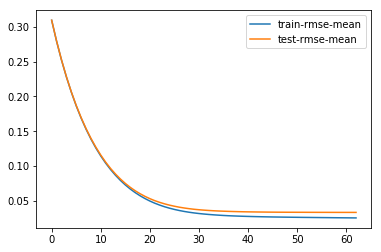

In [30]:
result_e0[['train-rmse-mean', 'test-rmse-mean']].plot();

In [31]:
model_e0 = xgb.train(param, dtrain_e0, len(result_e0))
#model_e0 = xgb.train(param, dtrain_e0, 59)

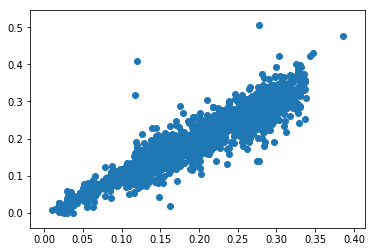

In [32]:
plt.scatter(model_e0.predict(dtrain_e0), y_e0_train);

In [33]:
result_bg = xgb.cv(param, dtrain_bg, num_round, nfold=5,
                   metrics={'rmse'}, seed=42,
                   callbacks=[xgb.callback.print_evaluation(show_stdv=True)],
                   early_stopping_rounds=10)

[0]	train-rmse:1.68999+0.0142307	test-rmse:1.68973+0.0576802
[1]	train-rmse:1.52718+0.012762	test-rmse:1.52804+0.0520976
[2]	train-rmse:1.38063+0.0115422	test-rmse:1.38221+0.046874
[3]	train-rmse:1.24903+0.0102348	test-rmse:1.25138+0.0422503
[4]	train-rmse:1.13059+0.0093343	test-rmse:1.13381+0.0375034
[5]	train-rmse:1.02431+0.00803748	test-rmse:1.02911+0.0337422
[6]	train-rmse:0.928706+0.0070108	test-rmse:0.934883+0.0297348
[7]	train-rmse:0.842691+0.00624651	test-rmse:0.849795+0.0272074
[8]	train-rmse:0.7653+0.00565273	test-rmse:0.773691+0.0242313
[9]	train-rmse:0.695959+0.0051419	test-rmse:0.705537+0.0213899
[10]	train-rmse:0.633748+0.00477649	test-rmse:0.644426+0.0187352
[11]	train-rmse:0.578056+0.00444644	test-rmse:0.590577+0.0170244
[12]	train-rmse:0.528316+0.00406071	test-rmse:0.542628+0.0151459
[13]	train-rmse:0.484047+0.00380872	test-rmse:0.500003+0.0134555
[14]	train-rmse:0.444387+0.00365867	test-rmse:0.461849+0.0121476
[15]	train-rmse:0.409065+0.00341878	test-rmse:0.428941+0.0

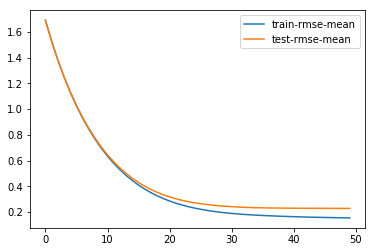

In [34]:
result_bg[['train-rmse-mean', 'test-rmse-mean']].plot();

In [35]:
model_bg = xgb.train(param, dtrain_bg, len(result_bg))
#model_bg = xgb.train(param, dtrain_bg, 59)

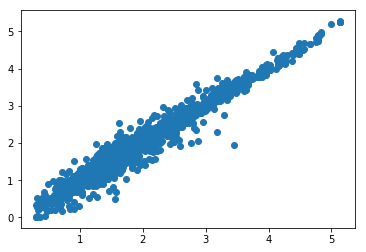

In [36]:
plt.scatter(model_bg.predict(dtrain_bg), y_bg_train);

#### Output predictions

In [37]:
predicted_bg = model_bg.predict(dtest)
predicted_e0 = np.expm1(model_e0.predict(dtest))

In [38]:
predicted = pd.DataFrame({'formation_energy_ev_natom': predicted_e0,
                          'bandgap_energy_ev': predicted_bg}) \
              .reset_index().rename(columns={'index': 'id'})
predicted['id'] += 1

In [39]:
predicted.head()

,id,bandgap_energy_ev,formation_energy_ev_natom
0,1,1.576747,0.204890
1,2,3.748866,0.062565
2,3,3.375566,0.163532
3,4,3.028989,0.031719
4,5,1.586242,0.138183


In [40]:
err_e0 = rmsle(np.expm1(model_e0.predict(dtrain_e0)), np.expm1(y_e0_train))
err_bg = rmsle(model_bg.predict(dtrain_bg), y_bg_train)

In [41]:
# Training RMSLE values
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.0660148164688, RMSLE E0: 0.0262373719559, RMSLE AVG: 0.0461260942124


#### Write to file

In [42]:
now = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
predicted.to_csv(os.path.join('output', 'xgb-ext-{}.csv'.format(now)),
                columns=['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'],
                index=False)